In [ ]:
#---- Time Series prediction with RNN----------

In [9]:
import os
os.getcwd()

'C:\\Users\\Nishanth\\Downloads\\New folder\\Sentiment-RNN-master'

In [36]:
### Load in necessary libraries for data input and normalization
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### load in and normalize the dataset
dataset = pd.read_csv('datasets/normalized_apple_prices.csv')
dataset = dataset.to_numpy()

In [37]:
dataset

array([[-0.82088484],
       [-0.93938305],
       [-0.9471652 ],
       [-0.68785527],
       [-0.84325902],
       [-0.80532018],
       [-0.82058073],
       [-0.92023124],
       [-1.        ],
       [-0.98814438],
       [-0.85961411],
       [-0.8706188 ],
       [-0.92661512],
       [-0.80118585],
       [-0.76288204],
       [-0.66499478],
       [-0.67289882],
       [-0.68220115],
       [-0.542119  ],
       [-0.46508592],
       [-0.21489592],
       [-0.17020823],
       [-0.08247456],
       [ 0.06411336],
       [ 0.0857576 ],
       [ 0.38604654],
       [ 0.39468034],
       [ 0.40708331],
       [ 0.55482607],
       [ 0.4571212 ],
       [ 0.217267  ],
       [ 0.38258092],
       [ 0.16187873],
       [ 0.16838432],
       [-0.00227998],
       [ 0.21903043],
       [ 0.16187873],
       [ 0.3212949 ],
       [ 0.21939484],
       [ 0.2579419 ],
       [ 0.30311627],
       [ 0.42818056],
       [ 0.42708622],
       [ 0.36190893],
       [ 0.34075119],
       [ 0

Text(0, 0.5, 'normalized series value')

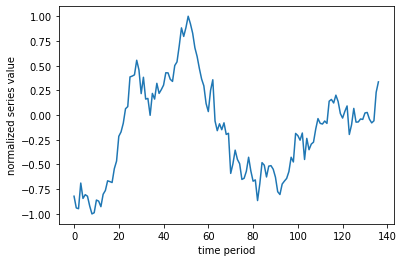

In [38]:
# lets take a look at our time series
plt.plot(dataset)
plt.xlabel('time period')
plt.ylabel('normalized series value')

In [39]:
odd_nums = np.array([1,3,5,7,9,11,13])

#In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on
def window_transform_series(series,window_size):
    # containers for input/output pairs
    X = []
    y = []
    
    # From 0 to p-t
    for i in range(len(series) - window_size):  
        inp = []
        
        # Pick next window_size elems
        for j in range(i, i + window_size):
            inp.append(series[j])
            
        # Add input and output
        X.append(inp)
        y.append(series[i+window_size])
        
        
    # reshape each 
    X = np.asarray(X)
    X.shape = (np.shape(X)[0:2])
    y = np.asarray(y)
    y.shape = (len(y),1)
    
    return X,y

In [40]:
# run a window of size 2 over the odd number sequence and display the results
window_size = 2
X,y = window_transform_series(odd_nums, window_size)

# print out input/output pairs --> here input = X, corresponding output = y
print ('--- the input X will look like ----')
print (X)

print ('--- the associated output y will look like ----')
print (y)

print ('the shape of X is ' + str(np.shape(X)))
print ('the shape of y is ' + str(np.shape(y)))
print('the type of X is ' + str(type(X)))
print('the type of y is ' + str(type(y)))

--- the input X will look like ----
[[ 1  3]
 [ 3  5]
 [ 5  7]
 [ 7  9]
 [ 9 11]]
--- the associated output y will look like ----
[[ 5]
 [ 7]
 [ 9]
 [11]
 [13]]
the shape of X is (5, 2)
the shape of y is (5, 1)
the type of X is <class 'numpy.ndarray'>
the type of y is <class 'numpy.ndarray'>


In [41]:
window_size = 7
X,y = window_transform_series(series = dataset,window_size = window_size)

In [42]:
X

array([[-0.82088484, -0.93938305, -0.9471652 , -0.68785527, -0.84325902,
        -0.80532018, -0.82058073],
       [-0.93938305, -0.9471652 , -0.68785527, -0.84325902, -0.80532018,
        -0.82058073, -0.92023124],
       [-0.9471652 , -0.68785527, -0.84325902, -0.80532018, -0.82058073,
        -0.92023124, -1.        ],
       [-0.68785527, -0.84325902, -0.80532018, -0.82058073, -0.92023124,
        -1.        , -0.98814438],
       [-0.84325902, -0.80532018, -0.82058073, -0.92023124, -1.        ,
        -0.98814438, -0.85961411],
       [-0.80532018, -0.82058073, -0.92023124, -1.        , -0.98814438,
        -0.85961411, -0.8706188 ],
       [-0.82058073, -0.92023124, -1.        , -0.98814438, -0.85961411,
        -0.8706188 , -0.92661512],
       [-0.92023124, -1.        , -0.98814438, -0.85961411, -0.8706188 ,
        -0.92661512, -0.80118585],
       [-1.        , -0.98814438, -0.85961411, -0.8706188 , -0.92661512,
        -0.80118585, -0.76288204],
       [-0.98814438, -0.8596

In [43]:
# split our dataset into training / testing sets
train_test_split = int(np.ceil(2*len(y)/float(3)))   # set the split point

# partition the training set
X_train = X[:train_test_split,:]
y_train = y[:train_test_split]

# keep the last chunk for testing
X_test = X[train_test_split:,:]
y_test = y[train_test_split:]

# NOTE: to use keras's RNN LSTM module our input must be reshaped to [samples, window size, stepsize] 
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

In [44]:
from tensorflow.keras import optimizers

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras

# given - fix random seed - so we can all reproduce the same results on our default time series
np.random.seed(0)

# lstm- 5 hidden units, inpput = 7, 1
model = Sequential()
model.add(LSTM(5, input_shape=(7, 1)))
model.add(Dense(1))

# rho = moving average = beta
optimizer = optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# compile the model
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5)                 140       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [46]:
%%time
# run your model!

model.fit(X_train, y_train, epochs=1000, batch_size=64, verbose=0)

Wall time: 30.7 s


In [47]:
# generate predictions for training
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [48]:
# print out training and testing errors
training_error = model.evaluate(X_train, y_train, verbose=0)
print('training error = ' + str(training_error))

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('testing error = ' + str(testing_error))

training error = 0.016469351947307587
testing error = 0.014287264086306095


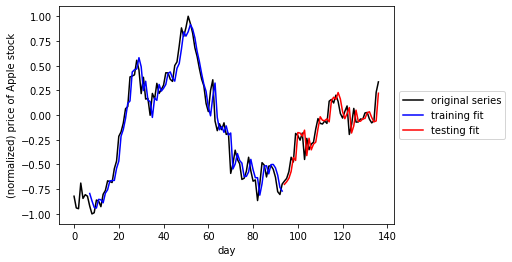

In [49]:
### Plot everything - the original series as well as predictions on training and testing sets
import matplotlib.pyplot as plt
%matplotlib inline

# plot original series
plt.plot(dataset,color = 'k')

# plot training set prediction
split_pt = train_test_split + window_size 
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# plot testing set prediction
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('(normalized) price of Apple stock')
plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()